***這是一個可以用系上搶運動場地的使用者帳號自動登入體育館網站搶場地的爬蟲程式
你只需要在下一格輸入系上的帳號、要搶的場地及時段，按下全部執行即可***

In [ ]:
!/opt/bin/nvidia-smi

/bin/bash: /opt/bin/nvidia-smi: No such file or directory


In [ ]:
#對照表
stadium_choices = {'羽球夜' : "羽球場  (夜間)",
      '羽球早' : "羽球場  (晨間)",
      '桌球' : "桌球室",
      '網球' : "網球場",
      '籃球' : "室外籃球場",
      '足球' : "五人制足球場",
      '排球早' : "室外排球場（晨間）",
      '排球晚' : "室外排球場（夜間）",
      '田徑場' : "田徑場(含投打練習場) (測試中)",
}


In [ ]:
#請參考
account = 'Vpm-EECS'#字符串中輸入帳號，例:'input_account'
password = '2020eecs'#輸入密碼
stadium = stadium_choices['排球晚']
date = '2022/03/08 星期二'#請輸入日期，星期，中間空一格，像:2020/02/14 星期一
min = 0
hour = 0 #設定要搶場地的時間，記得必須提前三分鐘跑程式，24小時制
field_num = 14 #場地順序先場地在加時段，例:總共有五個場五個時段要搶第二場第三時段就是5*2+2=12
error = 0#紀錄辨識錯誤的次數
add = 0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1.整理程式
2.把sleep 改成顯示等待
3.加入時鐘以便在整點時搶場地
4.將幾種會用到的場地整理成字典:排球、籃球、羽球場，還有時段
5.如果驗證錯誤則重新跑一次

In [ ]:
#!apt-get update #更新apt，可以不執行

In [ ]:
#!apt-get install python3-pip #下載最新版的pip，可以不執行

In [ ]:
!pip install selenium #安裝網站操控模組

In [ ]:

!apt install chromium-chromedriver #安裝chrome驅動以便selenium驅動chrome瀏覽器


Reading package lists... Done
Building dependency tree       
Reading state information... Done
chromium-chromedriver is already the newest version (97.0.4692.71-0ubuntu0.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
!dpkg --configure -a

In [ ]:
!cp /usr/lib/chromium-browser/chromedriver /usr/bin #複製chromedriver到bin目錄下

cp: '/usr/lib/chromium-browser/chromedriver' and '/usr/bin/chromedriver' are the same file


In [ ]:
import sys # 將chromedriver 設為環境變數
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

In [ ]:
from selenium import webdriver #瀏覽器驅動器
from selenium.webdriver.common.keys import Keys#鍵盤事件Keys類，參考https://www.cnblogs.com/ZhengYing0813/p/12447761.html
from selenium.webdriver.common.by import By#定位器，用於定位html中的各種元素
from selenium.webdriver.support import expected_conditions as EC#檢視是否符合指定條件。回傳TRUE,FALSE
from selenium.webdriver.support.wait import WebDriverWait#顯式等待，與EC結合使用，參考https://blog.csdn.net/sinat_41774836/article/details/88965281
from selenium.webdriver.support.ui import Select
from selenium.common.exceptions import UnexpectedAlertPresentException
from selenium.common.exceptions import NoSuchElementException
import pandas as pd#分析資料用
from PIL import Image#操作圖片用
import time
import datetime
from typing_extensions import final
import cv2 as cv#圖片處理
from google.colab.patches import cv2_imshow#輸出圖片
import numpy as np#數學、矩陣運算
from PIL import Image#存取圖片用
import os#控制主機


#瀏覽器驅動設定值
chrome_options = webdriver.ChromeOptions() #初始化瀏覽器參數
chrome_options.add_argument('--headless')#添加啟動參數，沒有開啟視窗；此部分有錯誤不能在colab中打開視窗
chrome_options.add_argument('--no-sandbox')#添加參數沒有沙盒
chrome_options.add_argument('--disable-dev-shm-usage')#停用 /dev/shm資料夾，原因不明
browser = webdriver.Chrome('chromedriver',options=chrome_options)#指定google chrome為瀏覽器
wait = WebDriverWait(browser,5, 0.5)#指定等待參數

url = 'http://pe.nchu.edu.tw/NewVenueRental/'#學校體育室網站

w, h = 800, 600#瀏覽器要設置的視窗大小

In [ ]:
#mse均方差損失函數，可以找到兩圖片在數學空間上的距離有多大，誤差越小越相近，參考https://bigdatafinance.tw/index.php/news/607-5
def mse(imgA, imgB):
  err = np.sum((imgA.astype(np.float32)/255 - imgB.astype(np.float32)/255) ** 2)
  err /= float(imgA.shape[0] * imgA.shape[1])
  return err



In [ ]:

"""def getNumber(pic,h,w):
  min_a = 999999999 #誤差值，先設很大
  min_png  = None #資料庫圖片的檔名
  for png in os.listdir('/content/drive/MyDrive/chapter'):
    ref = cv.imread('/content/drive/MyDrive/chapter/'+png)#讀取圖片
    #print('/content/drive/MyDrive/chapter/'+png)
    ref = cv.resize(ref, (300, 300))#以防萬一google在上傳照片時改了照片大小，resize一次
    sp1 = ref.shape#找到圖片尺寸到小參數
    if abs(h-sp1[0]) <= 10 and abs(w-sp1[1]) <= 10:#以防萬一，誤差在十以內才開始辨識
      if mse(ref, pic) < min_a :#呼叫mse函式，且如果誤差值小於先前的誤差值，則替換min_png，重複直到找到最小誤差值
        min_a = mse(ref, pic)
        min_png = png
  return min_png[0]#輸出照店檔名第一個字，也就是辨識出來的字元"""

"def getNumber(pic,h,w):\n  min_a = 999999999 #誤差值，先設很大\n  min_png  = None #資料庫圖片的檔名\n  for png in os.listdir('/content/drive/MyDrive/chapter'):\n    ref = cv.imread('/content/drive/MyDrive/chapter/'+png)#讀取圖片\n    #print('/content/drive/MyDrive/chapter/'+png)\n    ref = cv.resize(ref, (300, 300))#以防萬一google在上傳照片時改了照片大小，resize一次\n    sp1 = ref.shape#找到圖片尺寸到小參數\n    if abs(h-sp1[0]) <= 10 and abs(w-sp1[1]) <= 10:#以防萬一，誤差在十以內才開始辨識\n      if mse(ref, pic) < min_a :#呼叫mse函式，且如果誤差值小於先前的誤差值，則替換min_png，重複直到找到最小誤差值\n        min_a = mse(ref, pic)\n        min_png = png\n  return min_png[0]#輸出照店檔名第一個字，也就是辨識出來的字元"

In [ ]:
def getNumber(pic,h,w,mode):
  min_a = 999999999 #誤差值，先設很大
  min_png  = None #資料庫圖片的檔名
  pic = cv.resize(pic,(300,300))
  print(h,w)
  if h >= 130:
    for weight in os.listdir('/content/drive/MyDrive/chapter/131'):
      #print(weight)
      if abs(w - int(weight)) <= 2:
        for png in os.listdir('/content/drive/MyDrive/chapter/131/' + str(weight)):
          #print(png)
          ref = cv.imread('/content/drive/MyDrive/chapter/131/'+str(weight)+'/'+png)
          #print('/content/drive/MyDrive/chapter/131/'+str(weight)+'/'+png)
          ref = cv.resize(ref, (300, 300))#以防萬一google在上傳照片時改了照片大小，resize一次
          #if abs(h-sp1[0]) <= 10 and abs(w-sp1[1]) <= 10:#以防萬一，誤差在十以內才開始辨識
          MSE = mse(ref, pic)
          if  MSE >=0.001 and MSE < 0.4:
            min_a = MSE
            min_png = png
            print(min_a)
            return min_png[0]
          elif MSE < min_a :#呼叫mse函式，且如果誤差值小於先前的誤差值，則替換min_png，重複直到找到最小誤差值
            min_a = MSE
            min_png = png
  elif h < 130 :
    for weight in os.listdir('/content/drive/MyDrive/chapter/130'):
      if abs(w - int(weight)) <= 2:
        for png in os.listdir('/content/drive/MyDrive/chapter/130/' + weight):
          ref = cv.imread('/content/drive/MyDrive/chapter/130/'+str(weight)+'/'+png)#讀取圖片
          ref = cv.resize(ref, (300, 300))#以防萬一google在上傳照片時改了照片大小，resize一次
          #if abs(h-sp1[0]) <= 10 and abs(w-sp1[1]) <= 10:#以防萬一，誤差在十以內才開始辨識
          MSE = mse(ref, pic)
          if  MSE >=0.001 and MSE < 0.4:
            min_a = MSE
            min_png = png
            print(min_a)
            return min_png[0]
          elif MSE  < min_a :#呼叫mse函式，且如果誤差值小於先前的誤差值，則替換min_png，重複直到找到最小誤差值
            min_a = MSE
            min_png = png
  print(min_a)
  #查看是否會有照片尺寸與資料庫中不同的例外
  try :
    print(min_png[0])
    if min_a > 1 :
      if mode == 1:#是在登錄時出錯，重跑一次登陸程式
        recog_login_captcha()
      elif mode == 2:
        browser.get(browser.current_url)#是在確認要搶的場地時出錯，重搶一次場地
      recog_check_captcha()
  except TypeError :
    if mode == 1:#是在登錄時出錯，重跑一次登陸程式
      recog_login_captcha()
    elif mode == 2:
      browser.get(browser.current_url)#是在確認要搶的場地時出錯，重搶一次場地
      recog_check_captcha()
  return min_png[0]#輸出照店檔名第一個字，也就是辨識出來的字元

In [ ]:
def recognize_login(photo):
  kernel = np.ones((5,5),np.uint8)#捲積大小，由於opencv圖片讀取是用uint8格式，數值是介於0~255之間
  kernel_1 = np.ones((5,5),np.uint8)
  img = cv.imread(photo)#讀取圖片
  img = cv.resize(img, (1500, 300))#放大圖片，此處驗證碼長寬比5:1
  #cv2_imshow(img)

  gray_img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)#轉成灰階圖片


  ret, thresh = cv.threshold(gray_img,0,255,cv.THRESH_BINARY_INV | cv.THRESH_OTSU)#用閥值來去除雜訊，使用的演算法為黑白反轉以及大津二質化，參考https://www.wongwonggoods.com/python/python_opencv/opencv-threshold-all-otsu/
  #cv2_imshow(thresh)
  erosion = cv.erode(thresh, kernel , iterations = 3)#侵蝕圖片，讓小於kernal的躁點消失，且運行3次。跌帶次數越少，所需時間越短
  #cv2_imshow(erosion)
  dilation = cv.dilate(erosion, kernel, iterations = 4)#膨脹圖片，讓數字及字母膨脹圖片，讓數字及字母變大
  #cv2_imshow(dilation)
  final_img = cv.cvtColor(dilation,cv.COLOR_GRAY2BGR)#再把圖片轉回BGR模式以便找到輪廓
  #final_img = cv.cvtColor(final_img,cv.COLOR_BGR2HSV)

  cv.bitwise_not(thresh, thresh)#0~1,1~0

  contours, hierarchy = cv.findContours(dilation,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)#找到外圍輪廓，參考https://blog.csdn.net/dcrmg/article/details/51987348
  contours = [c for c in contours if cv.contourArea(c) > 1100]#把找到的輪廓排列取大於1100的
  contours = sorted(contours, key=cv.contourArea, reverse=True)[:5]
  #cv.drawContours(final_img,contours,-1,(0,255,0),3)#畫出輪廓
  for ctr in range(len(contours)):
    for ctrr in range(len(contours)):
      momA = cv.moments(contours[ctr])#找每個輪廓在圖片中的質量矩進而得到中心位置，然後由左到右排列
      (xa,ya) = int(momA['m10']/momA['m00']),int(momA['m01']/momA['m00'])
      momB = cv.moments(contours[ctrr])
      (xb,yb) = int(momB['m10']/momB['m00']),int(momB['m01']/momB['m00'])
      if xa<xb:
        contours[ctr],contours[ctrr] = contours[ctrr],contours[ctr]
  #cv2_imshow(dilation)
  rects = [cv.boundingRect(ctr) for ctr in contours]#把輪廓用四邊形圍起來
  #print(rects)
  breakcode = ''#儲存驗證碼的空字串

  #裁切每個字母並改變大小統一為300X300，由於資料庫中的圖片也是從這個程式裁切而成，所以不用擔心圖片變形
  for rect in rects:
    #cv.rectangle(final_img,(rect[0],rect[1]),(rect[0]+rect[2],rect[1]+rect[3]),(0,255,0),3)
    #cv2_imshow(final_img)
    roi = final_img[int(rect[1]):int(rect[1]+rect[3]),int(rect[0]):int(rect[0]+rect[2])]
    cv2_imshow(roi)
    size = roi.shape
    print(size)

   # cv2_imshow(roi)

    #sp = roi.shape#找到圖片尺寸大小
    #print(sp)
    breakcode += getNumber(roi,size[0],size[1],1)#呼叫便是個別單一數字的函式

  print(breakcode)
  return breakcode



In [ ]:
def recognize_check(photo):
  kernel = np.ones((5,5),np.uint8)#捲積大小，由於opencv圖片讀取是用uint8格式，數值是介於0~255之間
  kernel_1 = np.ones((5,5),np.uint8)
  img = cv.imread(photo)#讀取圖片
  img = cv.resize(img, (1500, 300))#放大圖片，此處驗證碼長寬比5:1
  #cv2_imshow(img)

  gray_img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)#轉成灰階圖片


  ret, thresh = cv.threshold(gray_img,0,255,cv.THRESH_BINARY_INV | cv.THRESH_OTSU)#用閥值來去除雜訊，使用的演算法為黑白反轉以及大津二質化，參考https://www.wongwonggoods.com/python/python_opencv/opencv-threshold-all-otsu/
  #cv2_imshow(thresh)
  erosion = cv.erode(thresh, kernel , iterations = 3)#侵蝕圖片，讓小於kernal的躁點消失，且運行6次
  #cv2_imshow(erosion)
  dilation = cv.dilate(erosion, kernel, iterations = 4)#膨脹圖片，讓數字及字母膨脹圖片，讓數字及字母變大
  #cv2_imshow(dilation)
  final_img = cv.cvtColor(dilation,cv.COLOR_GRAY2BGR)#再把圖片轉回BGR模式以便找到輪廓
  #final_img = cv.cvtColor(final_img,cv.COLOR_BGR2HSV)

  cv.bitwise_not(thresh, thresh)#0~1,1~0

  contours, hierarchy = cv.findContours(dilation,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)#找到外圍輪廓，參考https://blog.csdn.net/dcrmg/article/details/51987348
  contours = [c for c in contours if cv.contourArea(c) > 1100]#把找到的輪廓排列取大於1100的
  contours = sorted(contours, key=cv.contourArea, reverse=True)[:5]
  #cv.drawContours(final_img,contours,-1,(0,255,0),3)#畫出輪廓
  for ctr in range(len(contours)):
    for ctrr in range(len(contours)):
      momA = cv.moments(contours[ctr])#找每個輪廓在圖片中的質量矩進而得到中心位置，然後由左到右排列
      (xa,ya) = int(momA['m10']/momA['m00']),int(momA['m01']/momA['m00'])
      momB = cv.moments(contours[ctrr])
      (xb,yb) = int(momB['m10']/momB['m00']),int(momB['m01']/momB['m00'])
      if xa<xb:
        contours[ctr],contours[ctrr] = contours[ctrr],contours[ctr]
  #cv2_imshow(dilation)
  rects = [cv.boundingRect(ctr) for ctr in contours]#把輪廓用四邊形圍起來
  #print(rects)
  breakcode = ''#儲存驗證碼的空字串

  #裁切每個字母並改變大小統一為300X300，由於資料庫中的圖片也是從這個程式裁切而成，所以不用擔心圖片變形
  for rect in rects:
    #cv.rectangle(final_img,(rect[0],rect[1]),(rect[0]+rect[2],rect[1]+rect[3]),(0,255,0),3)
    #cv2_imshow(final_img)
    roi = final_img[int(rect[1]):int(rect[1]+rect[3]),int(rect[0]):int(rect[0]+rect[2])]
    cv2_imshow(roi)
    size = roi.shape
    #cv2_imshow(roi)

    #sp = roi.shape#找到圖片尺寸大小
    #print(sp)
    breakcode += getNumber(roi,size[0],size[1],2)#呼叫便是個別單一數字的函式

  print(breakcode)
  return breakcode



In [ ]:


def rent_time_again(addition):
  browser.get('http://pe.nchu.edu.tw/NewVenueRental/?module=rent_pro')#應該不用跑，因為點擊的元素就是一個超連結
  global error
  #嘗試到下一個頁面執行程式，驗證碼輸入錯誤則會跑出警告視窗，則重跑一次登錄程式
  """try :
    ele = wait.until(EC.visibility_of_element_located((By.XPATH, '//a[@href="?module=rent_pro"]')))#顯示等待直到絕對路徑被找到
    choice  = browser.find_element(By.XPATH,'//a[@href="?module=rent_pro"]')#透過html節點找到預約場地的網址並點擊
  except UnexpectedAlertPresentException :
    error+=1
    recog_login_captcha()
  except NoSuchElementException:#若沒找到這個元素，則refresh網頁
    browser.refresh
    ele = wait.until(EC.visibility_of_element_located((By.XPATH, '//a[@href="?module=rent_pro"]')))
    choice  = browser.find_element(By.XPATH,'//a[@href="?module=rent_pro"]')#透過html節點找到預約場地的網址並點擊



  choice.click()"""




  ele = wait.until(EC.visibility_of_element_located((By.XPATH, "//select[@name='queryPlace']")))#顯示等待直到絕對路徑被找到
  element1 = browser.find_element(By.XPATH,"//select[@name='queryPlace']")#找到下拉式選單得絕對位置
  sel1 = Select(element1);#將下拉式選單用Select()函數控制
  sel1.select_by_visible_text(stadium)#選擇場地

  ele = wait.until(EC.visibility_of_element_located((By.XPATH, "//select[@name='date']")))#顯示等待直到絕對路徑被找到
  element2 = browser.find_element(By.XPATH,"//select[@name='date']")#原理同上，租借時間
  sel2 = Select(element2)



  submit = browser.find_element(By.XPATH,"//input[@value='查詢']")#找到查詢按鈕並點擊
  sel2.select_by_visible_text(date)




  submit.click()




  final_check(addition)
  #get_page_index()


In [ ]:

def final_fn():
  global add
  global error#最初宣告的變數
  c_url = browser.current_url
  ele = wait.until(EC.presence_of_element_located((By.XPATH,"//*[@id='rent_form']/table/tbody/tr[2]/td/table/tbody/tr[4]/td[2]")))
  number = browser.find_element(By.XPATH,"//*[@id='rent_form']/table/tbody/tr[2]/td/table/tbody/tr[4]/td[2]")
  #print(number.text)
  if number.text == '01' or number.text == '02':
    add+=1
    rent_time_again(add)
    #print(add)
  final_check_bottom = browser.find_element(By.NAME,'checkword')
  Image.open('check_captcha.png')
  capt = recognize_check('check_captcha.png')
  final_check_bottom.send_keys(capt)

  final_click = browser.find_element(By.NAME,'save')
  final_click.click()
  print('click')

  #試圖查看是否租借成功，若可以在新的頁面中找到modal這個元素，則代表執行成功了
  try :
    browser.refresh()
    ele = wait.until(EC.presence_of_element_located((By.ID,"modal")))#顯示等待，回傳 true or false
    print(error)
    sys.exit('場地租借完成')
  except UnexpectedAlertPresentException:#若驗證碼錯誤，則會跳出視窗警告
    error+=1
    browser.get(c_url)
    recog_check_captcha()
    print(error)
    sys.exit('場地租借完成')#因為是重跑一次，所以有可能累計很多次的回全沒跑完，以防萬一所以加個程式中斷點


In [ ]:
def recog_check_captcha():
  browser.set_window_size(w,h)#將瀏覽器設為指定大小
  browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")#滑到底部
  document_height_2 = browser.execute_script("return document.body.scrollHeight")#找到網站的高度
  browser.save_screenshot('bottom_2.png')#截圖
  captchaimage_2 = browser.find_element(By.ID,'imgcode')#找到驗整碼的絕對位置


  #設置驗整碼的上下左右四個位置
  left_2 = captchaimage_2.location['x'] + 2
  right_2 = left_2 + captchaimage_2.size['width'] -9.5
  top_2 = h - (document_height_2 - captchaimage_2.location['y'])-22
  bottom_2 = top_2 + captchaimage_2.size['height'] -8 #-5

  img_2 = Image.open('bottom_2.png')#打開圖片
  captcha_2  = img_2.crop((left_2,top_2,right_2,bottom_2))#裁切圖片
  captcha_2.save('check_captcha.png')#將驗證碼儲存



  final_fn()

In [ ]:
#找到瀏覽器當下網址中的所有超連結
def find_href():
  elements = browser.find_elements(By.XPATH,"//a[@href]")#找到所有href超連結，注意find_elements的s(代表複數個)
  print(len(elements))
  """for elem in elements:
    print(elem.get_attribute("href"))"""
  return elements

In [ ]:

def get_page_index():
  browser.get('http://pe.nchu.edu.tw/NewVenueRental/')
  try:
    print(browser.page_source)
  except Exception as e:
    print(str(e),E)




In [ ]:
def final_check(weight):
  ele = wait.until(EC.presence_of_all_elements_located((By.TAG_NAME,'a')))#顯示等待直到有任何一個超連結元素被找到
  all_ele = find_href()
  #browser.get('http://pe.nchu.edu.tw/NewVenueRental/index.php?module=rent_pro')
  #bollow_url = "?module=rent_pro&value=TjIwMjIwMjE"+str(week)+'LU'+str(t)+'wM'+str(stadium_number)+"==&p=4"
  #print(weight)
  uri = all_ele[23+field_num+weight].get_attribute("href")
  final_chioce = browser.find_element(By.XPATH,'//a[@href="{}"]'.format(uri[37:]))
  final_chioce.click()

  #browser.get('http://pe.nchu.edu.tw/NewVenueRental/index.php?module=rent_pro&value=TjIwMjIwMjE'+str(week)+'LU'+str(time)+'wM'+str(stadium_number)+'==&p=4')#直接進入想選的場地編號及時間的網址


  recog_check_captcha()

In [ ]:


def rent_time():
  global error
  #嘗試到下一個頁面執行程式，驗證碼輸入錯誤則會跑出警告視窗，則重跑一次登錄程式
  try :
    ele = wait.until(EC.visibility_of_element_located((By.XPATH, '//a[@href="?module=rent_pro"]')))#顯示等待直到絕對路徑被找到
    choice  = browser.find_element(By.XPATH,'//a[@href="?module=rent_pro"]')#透過html節點找到預約場地的網址並點擊
  except UnexpectedAlertPresentException :
    error+=1
    recog_login_captcha()
  except NoSuchElementException:#若沒找到這個元素，則refresh網頁
    browser.refresh
    ele = wait.until(EC.visibility_of_element_located((By.XPATH, '//a[@href="?module=rent_pro"]')))
    choice  = browser.find_element(By.XPATH,'//a[@href="?module=rent_pro"]')#透過html節點找到預約場地的網址並點擊



  choice.click()

  #browser.get('http://pe.nchu.edu.tw/NewVenueRental/index.php?module=rent_pro')#應該不用跑，因為點擊的元素就是一個超連結


  now = datetime.datetime.now(tz=datetime.timezone(datetime.timedelta(hours=8)))#現在時間
  print(datetime.datetime.now())
  while now.minute != min  or now.hour != hour  :#若與指定的時間不同則無限迴圈
    #print(now.minute)
    #print('時間還沒到')
    now = datetime.datetime.now(tz=datetime.timezone(datetime.timedelta(hours=8)))
  browser.refresh()

  ele = wait.until(EC.visibility_of_element_located((By.XPATH, "//select[@name='queryPlace']")))#顯示等待直到絕對路徑被找到
  element1 = browser.find_element(By.XPATH,"//select[@name='queryPlace']")#找到下拉式選單得絕對位置
  sel1 = Select(element1);#將下拉式選單用Select()函數控制
  sel1.select_by_visible_text(stadium)#選擇場地

  ele = wait.until(EC.visibility_of_element_located((By.XPATH, "//select[@name='date']")))#顯示等待直到絕對路徑被找到
  element2 = browser.find_element(By.XPATH,"//select[@name='date']")#原理同上，租借時間
  sel2 = Select(element2)



  submit = browser.find_element(By.XPATH,"//input[@value='查詢']")#找到查詢按鈕並點擊
  sel2.select_by_visible_text(date)




  submit.click()




  final_check(0)
  #get_page_index()


In [ ]:


def login(cap):
  input = browser.find_element(By.NAME,"account")#透過名稱找到輸入帳號的框框
  input.send_keys(account)#輸入帳號


  #輸入密碼
  input = browser.find_element(By.NAME,"pwd")
  input.send_keys(password)


  #輸入驗證碼
  input = browser.find_element(By.NAME,"checkword")
  input.send_keys(cap)


  #找到登入件並點擊它

  commit = browser.find_element(By.NAME,'login')
  commit.click()


  #get_page_index()

  rent_time()



In [ ]:
def recog_login_captcha():


  global url

  browser.get(url)



  browser.set_window_size(w, h)
  browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")#下拉頁面到底部
  document_height  = browser.execute_script("return document.body.scrollHeight")#返回網站的高度非瀏覽器設置的600
  browser.save_screenshot('bottom.png')#截圖並儲存


  captchaimage = browser.find_element(By.ID,'imgcode')#透過元素在網站中的ID 尋找驗證碼在html中的element代號及位置

  #找到驗證碼圖片的上下左右位置
  left = captchaimage.location['x'] +2 #經過精算，各網站圖不一定一樣，captchaimage['x']為驗證碼圖片左上角點的x座標
  right = left + captchaimage.size['width'] -9.5
  top = h - (document_height - captchaimage.location['y']) -22
  bottom = top + captchaimage.size['height'] -8

  #打開剛才截圖的網站圖片
  img = Image.open('bottom.png')
  captcha = img.crop((left,top,right,bottom))#裁減圖片
  captcha.save('login_captcha.png')
  Image.open('login_captcha.png')
  captcha = recognize_login('login_captcha.png')

  login(captcha)


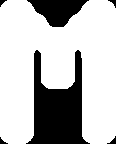

(144, 116, 3)
144 116
0.010230034044053819


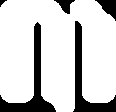

(112, 116, 3)
112 116
0.42721397569444447
m


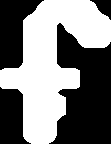

(144, 111, 3)
144 111
0.07101031358506944


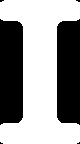

(144, 80, 3)
144 80
0.009946694607204862


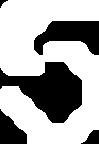

(144, 99, 3)
144 99
0.7842036458333334
e
mmfie


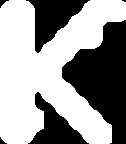

(144, 126, 3)
144 126
0.7552487847222222
k


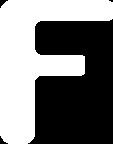

(144, 113, 3)
144 113
0.04706477864583333


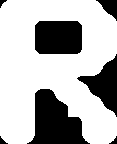

(144, 117, 3)
144 117
0.027209760199652776


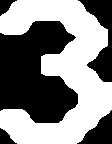

(144, 112, 3)
144 112
0.01734629855685764


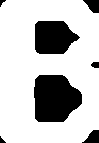

(143, 99, 3)
143 99
0.5522057291666667
e
kfr3e


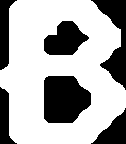

(144, 126, 3)
144 126
0.37960677083333333


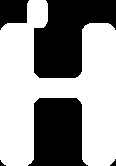

(166, 116, 3)
166 116
0.46797951388888887
h


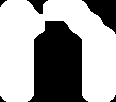

(102, 116, 3)
102 116
0.00810251193576389


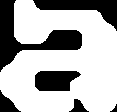

(112, 117, 3)
112 117
0.5755075954861111
a


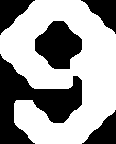

(144, 116, 3)
144 116
0.019589835611979165
bhna9
2022-03-01 15:50:13.518596
37


IndexError: ignored

In [ ]:
recog_login_captcha()